In [10]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# For text processing and word clouds
from wordcloud import WordCloud
import re

# For mapping
import folium
import os

from folium.plugins import HeatMap

# For machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score

# For transformers (we'll use a simple approach with sentence transformers)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [11]:
output_dir = 'output'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created '{output_dir}' directory")
else:
    print(f"'{output_dir}' directory already exists")

Created 'output' directory


In [12]:
# Load the Zurich Airbnb dataset
df = pd.read_csv('data/zurich_listings.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())



Dataset Shape: (2534, 75)

Column Names:
['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availa

In [13]:
print("\nFirst few rows:")
df.head()


First few rows:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,73282.0,https://www.airbnb.com/rooms/73282,2.023090e+13,9/24/2023,previous scrape,Rental unit in Zurich · ★4.78 · 1 bedroom · 1 ...,Arty neighborhood<br /><br /><b>The space</b><...,NaN,https://a0.muscache.com/pictures/481072/abd94c...,377532,https://www.airbnb.com/users/show/377532,Simona,2/4/2011,"Zurich, Switzerland",I am from Italy and have lived in Zurich for a...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/377532/profil...,https://a0.muscache.com/im/users/377532/profil...,NaN,1,1,"['email', 'phone']",t,t,NaN,Sihlfeld,Kreis 3,47.37167,8.51948,Entire rental unit,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Lake access"", ""Wifi"", ""Dryer"", ""TV with stan...",$100.00,1125,1125,1125,1125,1125,1125,1125.0,1125.0,NaN,t,23,53,83,358,9/24/2023,49,0,0,5/19/2012,4/27/2019,4.78,4.87,4.80,4.84,4.93,4.71,4.61,NaN,f,1,1,0,0,0.35
1,178448.0,https://www.airbnb.com/rooms/178448,2.023090e+13,9/24/2023,city scrape,Rental unit in Zurich · ★4.89 · 1 bedroom · 1 ...,"Very central location, 5 min walk from Bahnhof...","We live in one of the top locations of Zürich,...",https://a0.muscache.com/pictures/7d41e016-e818...,854016,https://www.airbnb.com/users/show/854016,Delphine,7/22/2011,"Zurich, Switzerland","I am a quiet, friendly and caring person\r\nI ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/854016/profil...,https://a0.muscache.com/im/users/854016/profil...,NaN,1,1,"['email', 'phone']",t,f,"Zurich, Switzerland",Enge,Kreis 2,47.36514,8.52615,Private room in rental unit,Private room,1,NaN,1 bath,NaN,1.0,"[""Hangers"", ""Lake access"", ""Shampoo"", ""Wifi"", ...",$60.00,5,31,5,5,31,31,5.0,31.0,NaN,t,0,0,0,235,9/24/2023,9,0,0,8/30/2011,5/10/2016,4.89,4.89,4.89,4.89,4.89,5.00,4.89,NaN,f,1,0,1,0,0.06
2,204586.0,https://www.airbnb.com/rooms/204586,2.023090e+13,9/24/2023,city scrape,Rental unit in Zurich · 1 bedroom · 1 bed · 1 ...,<b>The space</b><br />share a room in a very n...,NaN,https://a0.muscache.com/pictures/55486203/9834...,1004816,https://www.airbnb.com/users/show/1004816,Aicha,8/22/2011,"Zurich, Switzerland","I'm a very active person, love traveling, cook...",NaN,NaN,100%,f,https://a0.muscache.com/im/users/1004816/profi...,https://a0.muscache.com/im/users/1004816/profi...,NaN,1,1,"['email', 'phone']",t,f,NaN,Höngg,Kreis 10,47.40644,8.48385,Private room in rental unit,Private room,1,NaN,1 shared bath,NaN,1.0,"[""Wifi"", ""Dryer"", ""TV with standard cable"", ""K...",$200.00,3,6,3,3,6,6,3.0,6.0,NaN,t,29,59,86,351,9/24/2023,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
3,222565.0,https://www.airbnb.com/rooms/222565,2.023090e+13,9/24/2023,city scrape,Home in Zurich · ★4.60 · 1 bedroom · 1 bed · 1...,<b>The space</b><

In [14]:
# Calculate missing values for each column
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percentage', ascending=False)

# Show only columns with missing values
missing_data_filtered = missing_data[missing_data['Missing_Count'] > 0]
print(f"Columns with missing values: {len(missing_data_filtered)}\n")
print(missing_data_filtered.head(20))

Columns with missing values: 26

                                                  Column  Missing_Count  \
license                                          license           2534   
calendar_updated                        calendar_updated           2534   
bathrooms                                      bathrooms           2534   
host_neighbourhood                    host_neighbourhood           2499   
neighborhood_overview              neighborhood_overview           1334   
neighbourhood                              neighbourhood           1334   
host_about                                    host_about            993   
bedrooms                                        bedrooms            795   
review_scores_cleanliness      review_scores_cleanliness            561   
review_scores_accuracy            review_scores_accuracy            561   
review_scores_location            review_scores_location            561   
review_scores_value                  review_scores_value           

Figure saved to output/missing_values_analysis.png


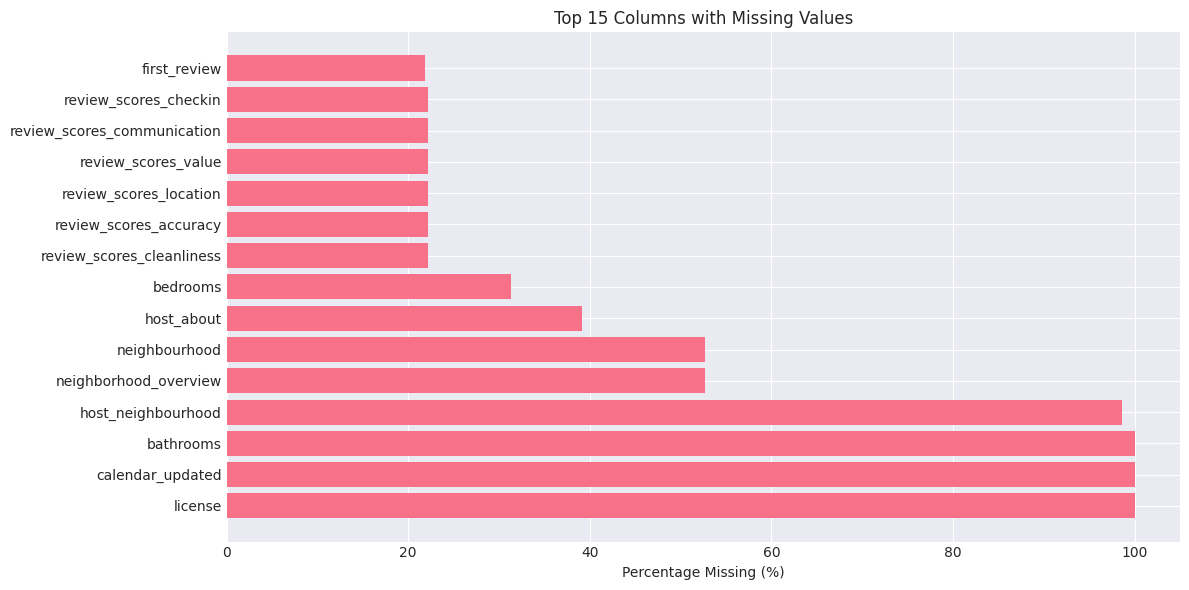

In [15]:
# Visualize missing data patterns
plt.figure(figsize=(12, 6))
top_missing = missing_data_filtered.head(15)
plt.barh(top_missing['Column'], top_missing['Missing_Percentage'])
plt.xlabel('Percentage Missing (%)')
plt.title('Top 15 Columns with Missing Values')
plt.tight_layout()
plt.savefig('output/missing_values_analysis.png', dpi=300, bbox_inches='tight')
print("Figure saved to output/missing_values_analysis.png")
plt.show()

In [17]:
# Create a working copy of the dataframe
df_clean = df.copy()

# 1. Handle price column - convert from string to numeric
def clean_price(price):
    """Convert price from string format to numeric"""
    if pd.isna(price):
        return np.nan
    # Remove '$' and ',' from price string
    return float(str(price).replace('$', '').replace(',', ''))

df_clean['price'] = df_clean['price'].apply(clean_price)

# 2. Fill text columns with empty strings
text_columns = ['description', 
                'neighborhood_overview', 
                'host_about', 
                'name']

for col in text_columns:
    df_clean[col] = df_clean[col].fillna('')

# 3. Handle numerical features with median imputation
numeric_features = ['bedrooms', 
                    'beds', 
                    'bathrooms']

for col in numeric_features:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f"Filled {col} missing values with median: {median_val}")

# 4. Handle host_response_time - create 'unknown' category
if 'host_response_time' in df_clean.columns:
    df_clean['host_response_time'] = df_clean['host_response_time'].fillna('unknown')

# 5. Fill review scores with median
review_columns = ['review_scores_rating', 
                  'review_scores_accuracy', 
                  'review_scores_cleanliness', 
                  'review_scores_checkin',
                  'review_scores_communication', 
                  'review_scores_location', 
                  'review_scores_value']

for col in review_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 6. Fill reviews_per_month with 0 (no reviews means 0 reviews per month)
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)

print("\n Missing Values After Treatment ")
print(f"Rows remaining: {len(df_clean)}")
print(f"\nColumns with missing values: {df_clean.isnull().sum().sum()}")
print("\nTop columns still with missing values:")

still_missing = df_clean.isnull().sum().sort_values(ascending=False).head(10)
print(still_missing[still_missing > 0])

Filled bedrooms missing values with median: 1.0
Filled beds missing values with median: 1.0
Filled bathrooms missing values with median: nan

 Missing Values After Treatment 
Rows remaining: 2534

Columns with missing values: 13917

Top columns still with missing values:
license                 2534
calendar_updated        2534
bathrooms               2534
host_neighbourhood      2499
neighbourhood           1334
first_review             553
last_review              553
host_response_rate       526
host_location            442
host_acceptance_rate     364
dtype: int64


In [ ]:
# Exploring data
print( "Number of unique neighborhoods:",
       df_clean['neighbourhood_cleansed'].nunique())
print("\nTop 10 neighborhoods by listing count:")
neighborhood_counts = df_clean['neighbourhood_cleansed'].value_counts().head(10)
print(neighborhood_counts)

Number of unique neighborhoods: 34

Top 10 neighborhoods by listing count:
neighbourhood_cleansed
Langstrasse     189
Sihlfeld        167
Altstetten      166
Oerlikon        134
Rathaus         129
Alt-Wiedikon    127
Unterstrass     118
Enge             93
Seefeld          93
Wollishofen      92
Name: count, dtype: int64


In [19]:
# Focus on top 10 neighborhoods for clearer analysis
top_neighborhoods = neighborhood_counts.index.tolist()
df_top_neighborhoods = df_clean[df_clean['neighbourhood_cleansed'].isin(top_neighborhoods)]

print(f"\nAnalyzing {len(df_top_neighborhoods)} listings across {len(top_neighborhoods)} neighborhoods")


Analyzing 1308 listings across 10 neighborhoods


In [21]:
# Summary Statistic 1: Average Price by Neighborhood
print("SUMMARY STATISTIC 1: Average Price by Neighborhood")

price_by_neighborhood = df_top_neighborhoods.groupby('neighbourhood_cleansed')['price'].agg([
    ('Mean Price (CHF)', 'mean'),
    ('Median Price (CHF)', 'median'),
    ('Std Dev', 'std'),
    ('Count', 'count')
]).round(2).sort_values('Mean Price (CHF)', ascending=False)

print("\n This shows which neighborhoods command premium prices. ")
print(price_by_neighborhood)


SUMMARY STATISTIC 1: Average Price by Neighborhood

 This shows which neighborhoods command premium prices. 
                        Mean Price (CHF)  Median Price (CHF)  Std Dev  Count
neighbourhood_cleansed                                                      
Rathaus                           267.86               150.0   262.15    129
Enge                              260.10               129.0  1007.73     93
Altstetten                        235.54               135.5   206.37    166
Seefeld                           234.69               163.0   264.78     93
Langstrasse                       190.87               144.0   152.37    189
Oerlikon                          187.76               130.0   161.07    134
Unterstrass                       182.39               137.5   214.29    118
Wollishofen                       170.37               140.0   169.05     92
Alt-Wiedikon                      154.72               119.0   143.24    127
Sihlfeld                          139.58    

In [23]:
# Summary Statistic 2: Property Type Distribution by Neighborhood
print("SUMMARY STATISTIC 2: Room Type Distribution by Neighborhood")


room_type_dist = pd.crosstab(
    df_top_neighborhoods['neighbourhood_cleansed'], 
    df_top_neighborhoods['room_type'], 
    normalize='index'
) * 100

print("\nThis reveals whether neighborhoods cater to different traveler types.")
print(room_type_dist.round(2))
print("High 'Entire home/apt' % suggests family-oriented areas; high 'Private room' suggests budget options.")

SUMMARY STATISTIC 2: Room Type Distribution by Neighborhood

This reveals whether neighborhoods cater to different traveler types.
room_type               Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_cleansed                                                        
Alt-Wiedikon                      77.95        0.00         22.05         0.00
Altstetten                        62.05        0.60         36.75         0.60
Enge                              67.74        0.00         32.26         0.00
Langstrasse                       73.02        0.53         25.40         1.06
Oerlikon                          67.91        0.00         32.09         0.00
Rathaus                           74.42        1.55         22.48         1.55
Seefeld                           86.02        0.00         13.98         0.00
Sihlfeld                          80.84        0.00         19.16         0.00
Unterstrass                       75.42        0.00         22.88         1.69


In [25]:
# Summary Statistic 3: Average Review Scores by Neighborhood
print("SUMMARY STATISTIC 3: Average Review Scores by Neighborhood")

review_by_neighborhood = df_top_neighborhoods.groupby('neighbourhood_cleansed').agg({
    'review_scores_rating': 'mean',
    'review_scores_location': 'mean',
    'review_scores_value': 'mean',
    'number_of_reviews': 'mean'
}).round(2).sort_values('review_scores_rating', ascending=False)

review_by_neighborhood.columns = ['Overall Rating', 'Location Score', 'Value Score', 'Avg # Reviews']
print("\n Higher location scores indicate desirable areas for tourists.")
print(review_by_neighborhood)
print("Discrepancies between overall rating and value suggest price sensitivity.")

SUMMARY STATISTIC 3: Average Review Scores by Neighborhood

 Higher location scores indicate desirable areas for tourists.
                        Overall Rating  Location Score  Value Score  \
neighbourhood_cleansed                                                
Unterstrass                       4.84            4.87         4.73   
Wollishofen                       4.83            4.81         4.70   
Langstrasse                       4.78            4.80         4.66   
Enge                              4.77            4.86         4.65   
Oerlikon                          4.77            4.75         4.61   
Seefeld                           4.76            4.90         4.68   
Sihlfeld                          4.74            4.83         4.62   
Altstetten                        4.73            4.69         4.61   
Alt-Wiedikon                      4.72            4.77         4.65   
Rathaus                           4.61            4.88         4.50   

                        

In [26]:
# Summary Statistic 4: Accommodation Capacity by Neighborhood
print("SUMMARY STATISTIC 4: Property Size Metrics by Neighborhood")

capacity_by_neighborhood = df_top_neighborhoods.groupby('neighbourhood_cleansed').agg({
    'accommodates': 'mean',
    'bedrooms': 'mean',
    'beds': 'mean',
    'bathrooms': 'mean'
}).round(2).sort_values('accommodates', ascending=False)

capacity_by_neighborhood.columns = ['Avg Guests', 
                                    'Avg Bedrooms', 
                                    'Avg Beds', 
                                    'Avg Bathrooms']
print("\nNeighborhoods with larger properties may cater to families or groups.")
print(capacity_by_neighborhood)
print("This metric helps understand the target demographic for each area.")

SUMMARY STATISTIC 4: Property Size Metrics by Neighborhood

Neighborhoods with larger properties may cater to families or groups.
                        Avg Guests  Avg Bedrooms  Avg Beds  Avg Bathrooms
neighbourhood_cleansed                                                   
Wollishofen                   3.04          1.30      1.90            NaN
Enge                          2.97          1.28      1.74            NaN
Oerlikon                      2.93          1.32      1.77            NaN
Unterstrass                   2.91          1.38      1.62            NaN
Seefeld                       2.84          1.19      1.54            NaN
Alt-Wiedikon                  2.82          1.31      1.69            NaN
Rathaus                       2.74          1.18      1.49            NaN
Langstrasse                   2.68          1.52      1.63            NaN
Altstetten                    2.55          1.16      1.45            NaN
Sihlfeld                      2.53          1.21      1.

In [27]:
# Summary Statistic 5: Host Response Metrics by Neighborhood
print("SUMMARY STATISTIC 5: Host Professionalism by Neighborhood")


# Clean host_response_rate (convert percentage string to float)
def clean_percentage(val):
    if pd.isna(val):
        return np.nan
    return float(str(val).replace('%', ''))

df_top_neighborhoods['host_response_rate_clean'] = df_top_neighborhoods['host_response_rate'].apply(clean_percentage)

host_metrics = df_top_neighborhoods.groupby('neighbourhood_cleansed').agg({
    'host_response_rate_clean': 'mean',
    'host_is_superhost': lambda x: (x == 't').sum() / len(x) * 100,
    'instant_bookable': lambda x: (x == 't').sum() / len(x) * 100,
    'host_total_listings_count': 'mean'
}).round(2).sort_values('host_response_rate_clean', ascending=False)

host_metrics.columns = ['Response Rate %', 'Superhost %', 'Instant Book %', 'Avg Listings per Host']
print("\nHigh superhost % and response rates indicate professional hosting culture.")
print(host_metrics)
print("Multiple listings per host may indicate commercial operations vs. individual hosts.")

SUMMARY STATISTIC 5: Host Professionalism by Neighborhood

High superhost % and response rates indicate professional hosting culture.
                        Response Rate %  Superhost %  Instant Book %  \
neighbourhood_cleansed                                                 
Rathaus                           98.03        26.36           41.09   
Alt-Wiedikon                      94.26        13.39           26.77   
Wollishofen                       93.87        15.22           17.39   
Altstetten                        93.84        16.87           44.58   
Unterstrass                       92.86        30.51           19.49   
Seefeld                           91.90        25.81           25.81   
Enge                              91.68        22.58           17.20   
Oerlikon                          91.59        18.66           25.37   
Sihlfeld                          91.42        15.57           23.35   
Langstrasse                       89.46        16.40           25.40   

 

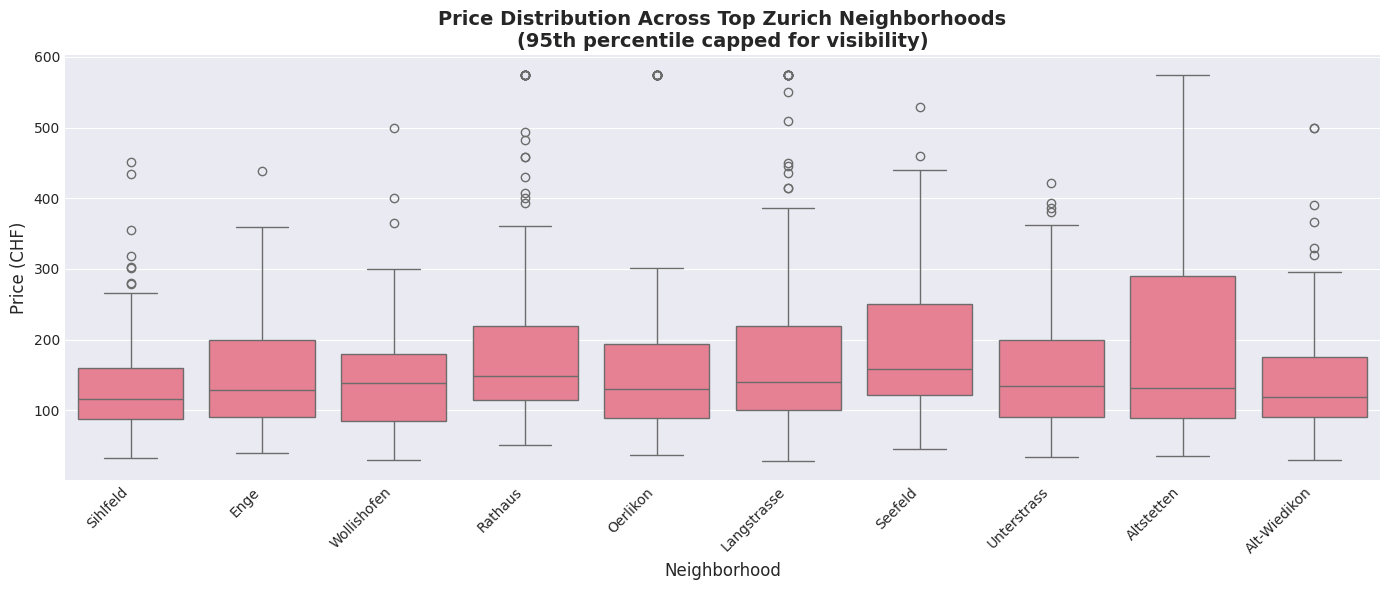

This box plot reveals price ranges and outliers in each neighborhood.
Wide boxes indicate diverse price points; narrow boxes suggest homogeneous pricing.


In [28]:
# Visualization 1: Box Plot - Price Distribution Across Top Neighborhoods
plt.figure(figsize=(14, 6))
# Filter extreme outliers for better visualization
price_data = df_top_neighborhoods[df_top_neighborhoods['price'] <= df_top_neighborhoods['price'].quantile(0.95)]

sns.boxplot(data=price_data, x='neighbourhood_cleansed', y='price')
plt.xticks(rotation=45, ha='right')
plt.title('Price Distribution Across Top Zurich Neighborhoods\n(95th percentile capped for visibility)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Price (CHF)', fontsize=12)
plt.tight_layout()
plt.savefig('output/price_distribution_neighborhoods.png', dpi=300, bbox_inches='tight')

plt.show()

print("This box plot reveals price ranges and outliers in each neighborhood.")
print("Wide boxes indicate diverse price points; narrow boxes suggest homogeneous pricing.")

<Figure size 1400x600 with 0 Axes>

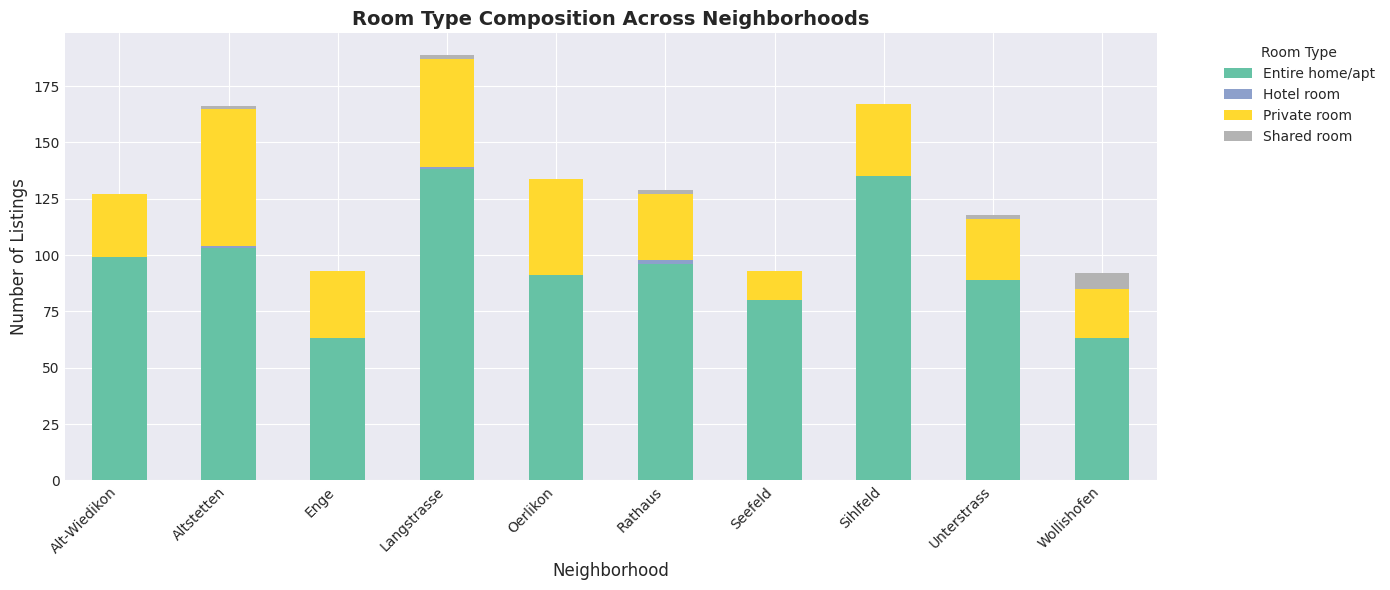

This stacked bar chart shows the absolute count of each room type per neighborhood.
Tall stacks indicate high supply; the color distribution shows market segmentation.


In [29]:
# Visualization 2: Stacked Bar Chart - Room Type Composition by Neighborhood
room_type_counts = pd.crosstab(
    df_top_neighborhoods['neighbourhood_cleansed'],
    df_top_neighborhoods['room_type']
)

plt.figure(figsize=(14, 6))
room_type_counts.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set2')
plt.title('Room Type Composition Across Neighborhoods', fontsize=14, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('output/room_type_composition.png', dpi=300, bbox_inches='tight')
plt.show()

print("This stacked bar chart shows the absolute count of each room type per neighborhood.")
print("Tall stacks indicate high supply; the color distribution shows market segmentation.")